In [2]:
import sys
print sys.path

import psycopg2 as ppg

con = ppg.connect("dbname=tweets user=patrick")
print con

['', '/home/patrick/anaconda/lib/python27.zip', '/home/patrick/anaconda/lib/python2.7', '/home/patrick/anaconda/lib/python2.7/plat-linux2', '/home/patrick/anaconda/lib/python2.7/lib-tk', '/home/patrick/anaconda/lib/python2.7/lib-old', '/home/patrick/anaconda/lib/python2.7/lib-dynload', '/home/patrick/anaconda/lib/python2.7/site-packages', '/home/patrick/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-linux-x86_64.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/setuptools-17.0-py2.7.egg', '/home/patrick/anaconda/lib/python2.7/site-packages/IPython/extensions']
<connection object at 0x7f49200cf280; dsn: 'dbname=tweets user=patrick', closed: 0>


In [3]:
#cur = con.cursor()
#cur.execute("SELECT tweet_id FROM tweets;")
#tweet_id = set(zip(*cur.fetchall())[0])
#cur.close()

Populating the interactive namespace from numpy and matplotlib
freq    298985
dtype: int64


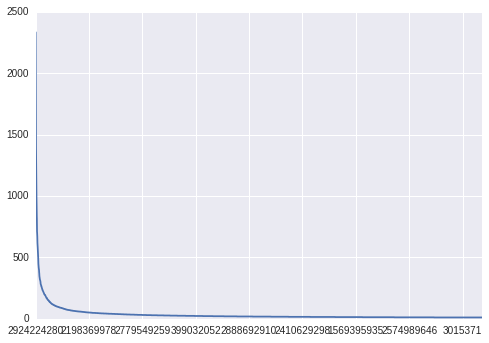

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd

with con.cursor() as cur:
    cur.execute("SELECT user_id FROM tweets;")
    users = zip(*cur.fetchall())[0]

user_counts = pd.DataFrame({ 'freq': pd.Series(users).value_counts() })
user_counts[user_counts.freq>10].freq.plot()
print user_counts[user_counts.freq>10].sum()

In [5]:
# with con.cursor() as cur:
#     cur.execute("SELECT tweet_id, user_id, in_reply_to_tweet_id FROM tweets")
#     tweets_list = cur.fetchall()
# tweets = pd.DataFrame(tweets_list, columns=['tweet_id','user_id','reply_id']).set_index('tweet_id')
# %timeit replied_to = tweets[tweets.reply_id != 'None'].reply_id.values
# tweet_ids = set(tweets.index)
# %timeit questions = tweets[[twid in replied_to for twid in tweet_ids]]
# print questions

In [6]:
# replies = tweets[tweets.reply_id != 'None']
# hanging_questions= pd.Series([rid for rid in replies.reply_id if rid not in questions.tweet_id.values])
# print hanging_questions

Base rate of @-mentions
Base rate of in-reply-to's
Find variation across users in in-reply-to's/total num. tweets
Ratio by user of outgoing @mention rate to in-reply-to (to all that user's tweets)

In [7]:
# # annotate tweets with initial @mention rate
# at_ment_re = re.compile(r"^\s+\.?@")
# tweets['at_mention'] = tweets.text.apply(lambda x:
#      at_ment_re.search(x) is not None)
                                         

# users_grps = tweets.groupby('user_id')
# users_df = users_grps.apply(lambda x: pd.DataFrame({'num_at_out': x.at_mention.sum(),
#                                                     'num_at_in': 
#reload(seaborn)
con.rollback()

In [8]:
# Explore geotags
usa = (-125.6791025,25.4180700649,-66.885417,
                           49.3284551525)    
with con.cursor() as cur:
    cur.execute("SELECT tw.tweet_id, tw.user_id, tw.lat, tw.long, user_locs.place, plcs.place_lat, "
                "plcs.place_long "
                "FROM tweets as tw, (SELECT user_id, place FROM users) as user_locs, "
                "(SELECT place, coded_lat as place_lat, coded_long as place_long FROM "
                "places) as plcs "
                "WHERE tw.user_id = user_locs.user_id and user_locs.place != 'None' "
                "and plcs.place = user_locs.place AND plcs.place_lat != -500 AND "
                "plcs.place_long != 500 AND (user_locs.place ~* '[A-Z\s]+,\s*[A-Z]+' OR "
                "user_locs.place ~* '(New York City|NYC|LA|Los Angeles|Chicago|DC|SF|San Francisco|"
                "Detroit|Houston|Dallas|Atlanta|Philly|Philadelphia|Phoenix|San Antonio| "
                "San Jose|Austin|Jacksonville|Indianapolis|Denver)');")
    geotags = pd.DataFrame(cur.fetchall(), 
                       columns=["tweet_id","user_id","tweet_lat","tweet_long","user_location",
                               "user_lat", "user_long"])
    in_us = pd.Series((geotags['tweet_long'] > usa[0]) & (geotags['tweet_long'] < usa[2]) &
                        (geotags['tweet_lat'] > usa[1]) & (geotags['tweet_lat'] < usa[3]))
    print in_us
    geotags['in_us'] = in_us
    # look at distance between user location and tweet location
 
    geotags['tweet_distance'] = np.sqrt((geotags.user_lat - geotags.tweet_lat) ** 2 + 
                                        (geotags.user_long - geotags.tweet_long) ** 2)
    geotags['on_road'] = geotags['tweet_distance'] > 0.5
    
    # get number of users w/ any on-road tweets, other per-user stats
    users_on_road=geotags.groupby('user_id').apply(lambda x: pd.Series([x.on_road.any(), x.on_road.sum(), x.shape[0]],
             index=['any_on_road','num_on_road','num_tweets_user'])).reset_index()
    geotags = geotags.merge(users_on_road, on='user_id')
    


0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
...
131697    True
131698    True
131699    True
131700    True
131701    True
131702    True
131703    True
131704    True
131705    True
131706    True
131707    True
131708    True
131709    True
131710    True
131711    True
Length: 131712, dtype: bool


In [9]:
print "Number NA user lat/long: " + str(geotags[['user_id', 'user_lat']].drop_duplicates().user_lat.isnull().sum())
print geotags.shape
geotags.head(10)

Number NA user lat/long: 0
(131712, 13)


,tweet_id,user_id,tweet_lat,tweet_long,user_location,user_lat,user_long,in_us,tweet_distance,on_road,any_on_road,num_on_road,num_tweets_user
0,608746364433014784,92652781,37.768900,-122.474176,Los Angeles,34.052227,-118.243680,True,5.631230,True,True,3,4
1,606606914382884864,92652781,37.775000,-122.418000,Los Angeles,34.052227,-118.243680,True,5.593209,True,True,3,4
2,608699447028121601,92652781,37.793230,-122.414480,Los Angeles,34.052227,-118.243680,True,5.602738,True,True,3,4
3,606539785600000000,92652781,34.196338,-118.352430,Los Angeles,34.052227,-118.243680,True,0.180540,False,True,3,4
4,608746355452870656,55979584,30.013785,-95.468449,"Houston, TX",29.763276,-95.363269,True,0.271694,False,False,0,1
5,606545644589715459,198020747,33.733886,-84.349284,Atlanta,33.748999,-84.387978,True,0.041541,False,False,0,1
6,606545674658643969,1262061,43.890851,-78.938497,"Whitby, ON",43.897545,-78.942933,True,0.008030,False,False,0,30
7,608004322232823808,1262061,43.890811,-78.938396,"Whitby, ON",43.897545,-78.942933,True,0.008119,False,False,0,30
8,608330462243766272,1262061,43.890811,-78.938403,"Whitby, ON",43.897545,-78.942933,True,0.008116,False,False,0,30
9,608330644238835712,1262061,43.890852,-78.938498,"Whitby, ON",43.897545,-78.942933,True,0.008029,False,False,0,30


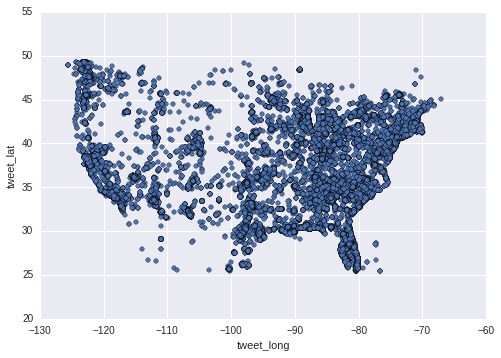

In [10]:
geotags[geotags['in_us']==True].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#LA

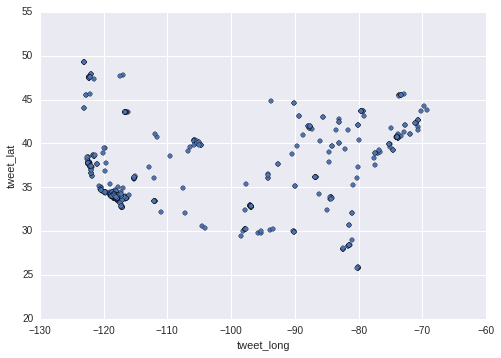

In [11]:
geotags[geotags['user_location']=="Los Angeles, CA"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

#NYC

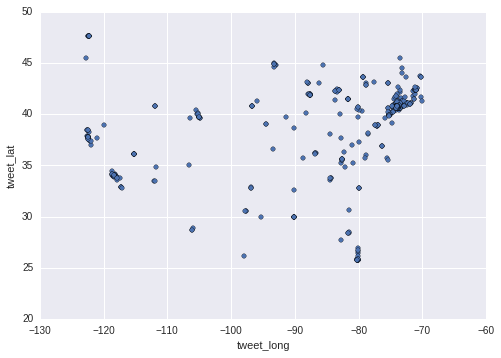

In [12]:
geotags[geotags['user_location']=="New York, NY"].plot(x='tweet_long',y='tweet_lat',kind='scatter')

0                    Los Angeles
42                  Appleton, WI
44                 Pensacola, FL
57                 Champaign, IL
478                New York City
484               Greenville, NC
485                   Boston, Ma
3313               San Francisco
3376                  Albany, NY
3377                   Cleveland
3398                 Seattle, WA
3491    Pittsburgh, Pennsylvania
3492                     Houston
3493         Boca Raton, Florida
4267                 Orlando, FL
...
130178              Beaufort, SC
130361            Marysville, WA
130375        Hermosillo, Sonora
130381               Compton, CA
130435            Parsippany, NJ
130436              Chicago area
130481    Fort Collins, Colorado
130610              Aberdeen, SD
130803            Lexington, KY 
130992        Las Vegas, NV, USA
131104     Milwaukee, Wisconsin 
131237     Arlington Heights, IL
131270             Kennesaw, GA 
131555        Las Vegas, Nevada 
131579           Pico Rivera, CA
Name: 

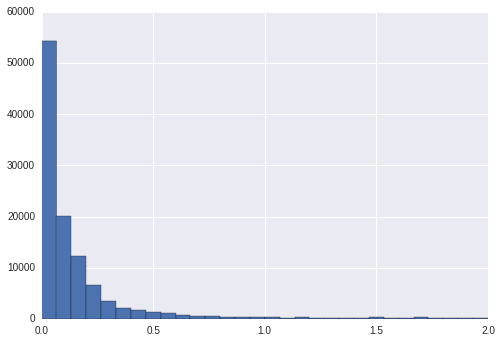

In [13]:
#print geotags.ix[np.argmax(geotags['tweet_distance'])]
#((geotags.user_lat - geotags.tweet_lat) ** 2).describe()
geotags[geotags.tweet_distance < 2].tweet_distance.hist(bins=30)
print geotags[geotags.tweet_distance > 0.5].user_location.drop_duplicates()


                 tweet_id   user_id  tweet_lat  tweet_long  \
91492  608708833209364480  17558759  36.994701  -86.440567   
91493  608671574548471809  17558759  37.011575  -86.366531   
91494  608395429747781633  17558759  36.985817  -86.456899   
91495  608396689595056129  17558759  36.985817  -86.456899   

                 user_location   user_lat  user_long in_us  tweet_distance  \
91492  St. Petersburg, Florida  27.773056     -82.64  True        9.974119   
91493  St. Petersburg, Florida  27.773056     -82.64  True        9.961790   
91494  St. Petersburg, Florida  27.773056     -82.64  True        9.972145   
91495  St. Petersburg, Florida  27.773056     -82.64  True        9.972145   

      on_road any_on_road  num_on_road  num_tweets_user  
91492    True        True            4                4  
91493    True        True            4                4  
91494    True        True            4                4  
91495    True        True            4                4  


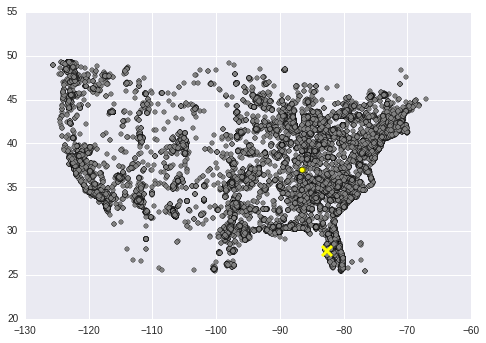

In [14]:
import random
plt.scatter(geotags[geotags['in_us']==True]['tweet_long'],geotags[geotags['in_us']==True]['tweet_lat'],
           c='gray')
# random user's home location
random_user = geotags.loc[random.sample(geotags[geotags.on_road].index, 1), 'user_id']


user_tweets = geotags[geotags['user_id']==random_user.values[0]]
print user_tweets
plt.scatter(user_tweets.tweet_long, user_tweets.tweet_lat,
            c='yellow', marker='.', s=100)
plt.scatter(user_tweets.user_long.drop_duplicates(), user_tweets.user_lat.drop_duplicates(), 
            c='yellow', marker='x', linewidth = '3', s=100)


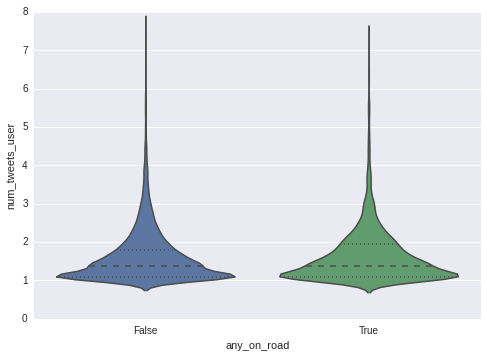

In [15]:
# compare number of tweets between on/off road
tweet_freqs = geotags[(geotags['num_tweets_user'] >= 3)][['user_id','num_tweets_user','any_on_road']]. \
    drop_duplicates()
#plt.axis([None, None, 0,5])

seaborn.violinplot(tweet_freqs.num_tweets_user.map(np.logb), groupby=tweet_freqs.any_on_road)

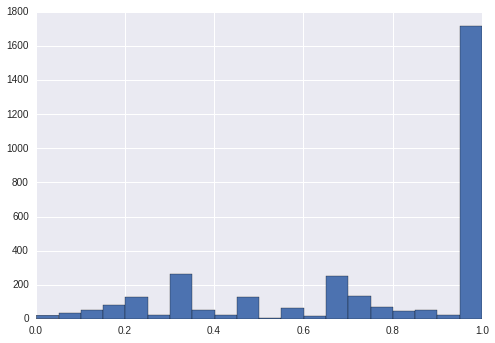

In [38]:
# for users who have 3+ tweets and any on road, 0-1 distribution of proportion of tweets on road?
geotags[(geotags['num_tweets_user'] >= 3) & (geotags.any_on_road > 0)]. \
    groupby('user_id').apply(
    lambda x: float(x.num_on_road.sum()) / float(x.num_tweets_user.sum())).hist(bins=20)

In [16]:
# do logistic regression on topic features
with con.cursor() as cur:
    cur.execute("SELECT user_id, " +
               ', '.join(["topic_{}".format(x) for x in range(0,40)]) +
               " FROM users WHERE topic_0 is not NULL")
    topic_matrix = pd.DataFrame(cur.fetchall(), columns = ["user_id"] + 
                           ["topic_{}".format(x) for x in range(0,40)])
geotopics = topic_matrix.merge(geotags[['user_id','any_on_road']].drop_duplicates(), on='user_id', how='left') 



In [17]:
print geotopics.dropna().any_on_road.shape[0]
print geotopics.dropna().any_on_road.sum()

response = geotopics.dropna()['any_on_road']
predictors = geotopics.dropna().loc[:,'topic_0':'topic_39']

39190
10584


In [18]:
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as skpre
import sklearn.cross_validation as skcv

random.seed(888)
train, test = skcv.train_test_split(pd.concat([pd.DataFrame(response), predictors], axis = 1))
train = pd.DataFrame(train, columns = ["any_on_road"] + predictors.columns.tolist())
test = pd.DataFrame(test, columns = ["any_on_road"] + predictors.columns.tolist())

scaler = skpre.StandardScaler()
scaler.fit(train.loc[:,"topic_0":"topic_39"])
train_scaled = scaler.transform(train.loc[:,"topic_0":"topic_39"])
test_scaled = scaler.transform(test.loc[:,"topic_0":"topic_39"])
#predictors_scaled = skpre.scale(predictors)
#test

/home/patrick/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: StandardScaler assumes floating point values as input, got object
  "got %s" % (estimator, X.dtype))


In [19]:
logmodel = LogisticRegression()
model_results = logmodel.fit(train_scaled,train.any_on_road)


In [22]:
predictions = model_results.predict(test_scaled)

In [23]:
print float((test.any_on_road == False).sum())/float(test.shape[0])

0.732598489488


In [24]:
print float((predictions == test.any_on_road).sum())/float(test.shape[0])

0.615533782405


In [25]:
print (predictions == True).sum()

3657


In [ ]:
# try SVM
from sklearn import svm
svmachine = svm.SVC(class_weight='auto')
model_results = svmachine.fit(train_scaled,train.any_on_road)

In [29]:
predictions = model_results.predict(test_scaled)

In [27]:
print float((test.any_on_road == False).sum())/float(test.shape[0])

0.732598489488


In [31]:
print float((predictions == test.any_on_road).sum())/float(test.shape[0])

0.593896713615
